# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [3]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726671e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


In [5]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)


In [6]:
# Define Actor for DDPG
class Actor(nn.Module):
    def __init__(self, state_size, action_size, seed):
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)        
        self.fc1 = nn.Linear(state_size, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, action_size)
        self.reset_parameters()
        
    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
        
    def forward(self, state):
        x = F.relu(self.bn1(self.fc1(state)))
        x = F.relu(self.fc2(x))
        x = F.tanh(self.fc3(x))
        return x

In [7]:
# Define Critic for DDPG
class Critic(nn.Module):
    def __init__(self, state_size, action_size, seed):
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)        
        self.fc1 = nn.Linear(state_size, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256+action_size, 128)
        self.fc3 = nn.Linear(128, 1)
        self.reset_parameters()
    
    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
        
    def forward(self, state, action):
        xs = F.relu(self.bn1(self.fc1(state)))
        x = torch.cat((xs, action), dim=1)        
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [8]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [9]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.1):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

In [10]:
import numpy as np
import random
import copy
from collections import namedtuple, deque

class Agent:
    def __init__(self, state_size, action_size, gamma, tau, batch_size, random_seed):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.tau = tau
        self.batch_size = batch_size
        self.seed = random.seed(random_seed)

        # actor network
        self.actor = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
                           
        # critic network
        self.critic = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        
        # optimizer
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=LR_ACTOR)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY_CRITIC)
        
        # Noise process
        self.noise = OUNoise(action_size, random_seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, self.batch_size, random_seed)
        
        # counter
        self.step_counter = 0
        
    def noise_reset(self):
        self.noise.reset()
        
    def act(self, state):
        state = torch.from_numpy(state).float().to(device)
        
        self.actor.eval()
        with torch.no_grad():
            action = self.actor(state).cpu().data.numpy()
        self.actor.train()
        
        action += self.noise.sample()
        action = np.clip(action, -1, 1)
        return action
    
    def store(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
        
    def sample(self):
        if len(self.memory) > self.batch_size:
            experiences = self.memory.sample()
            return experiences
        
        return ()
    
    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (self.gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor(states)
        actor_loss = -self.critic(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #

        self.soft_update(self.critic, self.critic_target, self.tau)
        self.soft_update(self.actor, self.actor_target, self.tau)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


In [11]:
BUFFER_SIZE = int(1e6) # replay buffer size
BATCH_SIZE = 512 # minibatch size
GAMMA = 0.9 # discount factor
TAU = 1e-3 # for soft update of target parameters
NUM_EPISODES = 1000
LR_ACTOR = 1e-3
LR_CRITIC = 1e-4
WEIGHT_DECAY_CRITIC = 0
UPDATE_EVERY = 5
UPDATE_TIMES = 1

In [12]:
def DDPG(
    env, brain_name, 
    state_size, action_size, 
    seed,
    gamma,
    tau,
    num_episodes, 
    batch_size,
):
    
    scores = []    
    scores_deque = deque(maxlen=100)
    agent = Agent(state_size, action_size, gamma, tau, batch_size, seed)
    step_counter = 0
    for i_episode in range(1, num_episodes+1):
        score = np.zeros(1)
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations
        agent.noise_reset()
        
        while True:
            action = agent.act(state)
            
            # get next_state, reward, done
            env_info = env.step(action)[brain_name]
            reward = env_info.rewards        
            next_state = env_info.vector_observations
            done = env_info.local_done
            
            # store transition
            agent.store(state, action, reward, next_state, done)

            step_counter = (step_counter + 1) % UPDATE_EVERY
            if step_counter == 0:
                for _ in range(UPDATE_TIMES):
                    # sample a random minibatch of N transitions from buffer
                    samples = agent.sample()
                    if len(samples) > 0:
                        agent.learn(samples)

            state = next_state            
            score += reward
            if np.any(done):
                break
        
        scores.append(score)
        scores_deque.append(score)
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
        
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            
        if np.mean(scores_deque) >= 30.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            torch.save(agent.actor.state_dict(), 'checkpoint_actor_final.pth')
            torch.save(agent.critic.state_dict(), 'checkpoint_critic_final.pth')
            break            
        
        
    return scores

In [13]:
scores = DDPG(
    env, brain_name,
    state_size, action_size,
    seed=1,
    gamma=GAMMA,
    tau=TAU,
    num_episodes=NUM_EPISODES,
    batch_size=BATCH_SIZE,
)


Episode 100	Average Score: 0.80
Episode 200	Average Score: 2.71
Episode 300	Average Score: 6.98
Episode 400	Average Score: 13.48
Episode 500	Average Score: 27.68
Episode 517	Average Score: 30.12
Environment solved in 517 episodes!	Average Score: 30.12


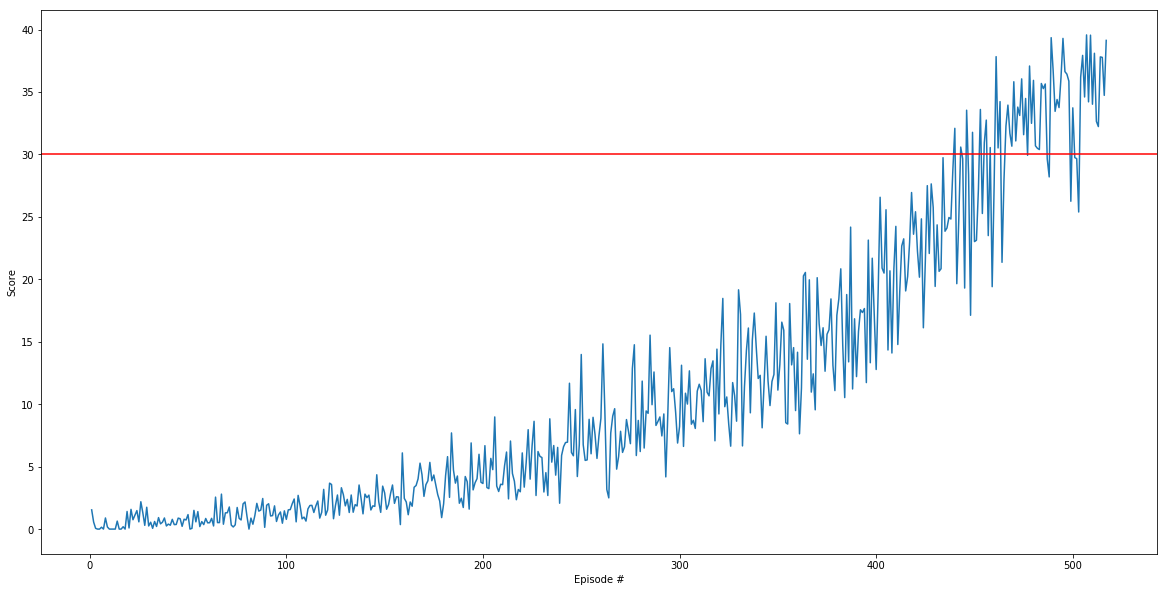

In [16]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
fig = plt.figure()
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.axhline(30, color='red')
plt.show()